<a href="https://colab.research.google.com/github/succSeeded/dl-2025/blob/main/hws/week03_convnets/seminar_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="https://github.com/yandexdataschool/deep_vision_and_graphics/blob/fall22/week02-convnets/cifar10.jpg?raw=1" style="width:80%">

In [1]:
# **IMPORTANT** when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/refs/heads/fall25/week03_convnets/cifar.py

--2025-09-29 17:46:32--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/refs/heads/fall25/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2025-09-29 17:46:32 (48.7 MB/s) - ‘cifar.py’ saved [2396/2396]



In [2]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


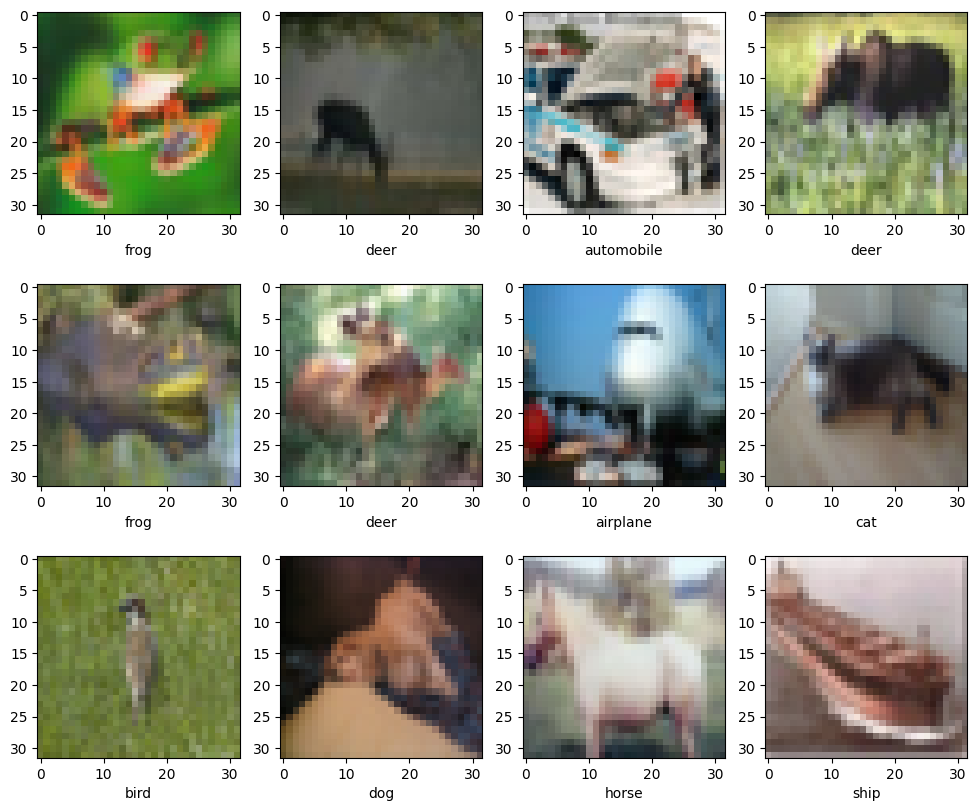

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

Let's start with a dense network for our baseline, then gradually improve it.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# model = nn.Sequential(
#     nn.Flatten(),  # reshape images to vectors; if you have conv / pool layers, they go BEFORE flatten
#     nn.Linear(3 * 32 * 32, 128),
#     nn.ReLU(),
#     nn.Linear(128, 10) # logits for 10 classes. No softmax - this is intentional
# )

# Initial model, not really optimal
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(3,3)),  # [32, 30, 30]
    nn.BatchNorm2d(32),
    nn.MaxPool2d((2,2)),                  # [32, 15, 15]
    nn.ReLU(),
    # A
    nn.Conv2d(32, 64, kernel_size=(3,3)), # [64, 13, 13]
    nn.BatchNorm2d(64),
    nn.MaxPool2d((2,2)),                  # [64, 6, 6]
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 6 * 6, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [5]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32, device=device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64, device=device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [6]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.1841, device='cuda:0', grad_fn=<MeanBackward0>)

There is `running_mean` property that is being actively changed. You are not supposed to do this in training(?)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [7]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [8]:
import time
num_epochs = 20 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.item())  # .item() = convert 1-value Tensor to float

    # And a full pass over the validation data:
    model.train(False)     # disable dropout / use averages for batch_norm
    with torch.no_grad():  # do not store intermediate activations
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            logits = model(torch.as_tensor(X_batch, dtype=torch.float32, device=device))
            y_pred = logits.argmax(-1).detach().cpu().numpy()
            val_accuracy.append(np.mean(y_batch == y_pred))

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 20 took 2.455s
  training loss (in-iteration): 	1.532326
  validation accuracy: 			56.85 %
Epoch 2 of 20 took 2.359s
  training loss (in-iteration): 	1.144755
  validation accuracy: 			52.66 %
Epoch 3 of 20 took 2.087s
  training loss (in-iteration): 	1.017498
  validation accuracy: 			62.06 %
Epoch 4 of 20 took 2.098s
  training loss (in-iteration): 	0.935084
  validation accuracy: 			57.46 %
Epoch 5 of 20 took 2.119s
  training loss (in-iteration): 	0.872355
  validation accuracy: 			58.66 %
Epoch 6 of 20 took 2.101s
  training loss (in-iteration): 	0.812432
  validation accuracy: 			68.75 %
Epoch 7 of 20 took 2.222s
  training loss (in-iteration): 	0.760958
  validation accuracy: 			68.14 %
Epoch 8 of 20 took 2.248s
  training loss (in-iteration): 	0.715875
  validation accuracy: 			67.31 %
Epoch 9 of 20 took 2.102s
  training loss (in-iteration): 	0.669976
  validation accuracy: 			72.55 %
Epoch 10 of 20 took 2.092s
  training loss (in-iteration): 	0.627735
  validation 

When to stop training? We can use earnest stopping: if the validation accuracy is not improving for `n` epochs --- stop training. `n` could be 5, 7, 10 or whatever we feel like.

Which model do we present as the final one? Its is best practice to save best-performing weights so that we can actually work with them. This can be done using the following syntax:

```
torch.save(model, path_to_model)
=== OR ====
torch.save(model.state_dict(), path_to_model)
```

And we load model using `torch.load_state_dict(path_to_model)`

We can also track `best_accuracy` and `best_epoch`.

Also also we can manipulate the dataset: rotate, enchance, crop pictures etc. This will just make the training set better by expanding it without necessarily making it works. We should find balance between dataset augmentation and overfitting. It is recommended to just horizontal flip the images in dataset (thus, increasing its size twofold). This can be done using `torch.torchvision`. Useful tools: `dataloader`.

If we have a powerful gpu+cpu we can use cpu to do some calculations during data augmentation by setting `num_workers` parameter.

We should take a look at additional sources on the course repo.

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [11]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32, device=device))
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		70.96 %
Achievement unlocked: 80lvl Warlock!


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [19]:
# ==============
# some prep work
# ==============

import time
import pathlib

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from cifar import load_cifar10


def compute_loss(X_batch: np.typing.ArrayLike, y_batch: np.typing.ArrayLike) -> torch.types.FloatLikeType:
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32, device=device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64, device=device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()


# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]


# **IMPORTANT** when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/refs/heads/fall25/week03_convnets/cifar.py

X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

device = "cuda" if torch.cuda.is_available() else "cpu"

--2025-09-29 19:45:09--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/refs/heads/fall25/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py.2’

cifar.py.2          100%[===================>]   2.34K  --.-KB/s    in 0s      

2025-09-29 19:45:09 (54.5 MB/s) - ‘cifar.py.2’ saved [2396/2396]



In [50]:
def train(model, opt, X_train, y_train, X_val, y_val, num_epochs:int = 100, batch_size:int = 64, stop:int = 7):
    """
    A function for training torch models that I kindly took from the professor (sorry)

    Args:
        model: torch model to train
        opt: optimizer for that model
        X_train: training data [n, m], where n is the number of entries and m --- the number of features
        y_train: training targets [n,]
        X_val: validation data
        y_val: validation targets
        num_epochs: total amount of full passes over training data (default: 100)
        batch_size: number of samples processed in one SGD iteration (default: 64)
        stop: number of iterations that loss can decrease for before the training proces stops (default: 7)
    """
    train_loss = []
    val_accuracy = []
    best_val_acc = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
            # train on batch
            loss = compute_loss(X_batch, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.item())  # .item() = convert 1-value Tensor to float

        # And a full pass over the validation data:
        model.train(False)     # disable dropout / use averages for batch_norm
        with torch.no_grad():  # do not store intermediate activations
            for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
                logits = model(torch.as_tensor(X_batch, dtype=torch.float32, device=device))
                y_pred = logits.argmax(-1).detach().cpu().numpy()
                val_accuracy.append(np.mean(y_batch == y_pred))

        mean_val_acc = np.mean(val_accuracy[-len(X_val) // batch_size :])

        if best_val_acc < mean_val_acc:
            best_val_acc = mean_val_acc
            best_epoch = i
            pathlib.Path("./models/").mkdir(exist_ok=True)
            torch.save(model.state_dict(), f"models/best_model.pt2")


        if epoch - best_epoch > stop:
            print("Model did not see any loss improvements for %i epochs, aborting..." % (stop))
            model.load_state_dict(torch.load(f"models/best_model.pt2", weights_only=True))
            model.eval()
            break

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            mean_val_acc * 100))

    print(f"Finished training. Best validation accuracy: {best_val_acc*100:.2f} %")

In [51]:
def evaluate(model, X_test, y_test):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32, device=device))
        y_pred = logits.max(1)[1].data.cpu().numpy()
        test_batch_acc.append(np.mean(y_batch == y_pred))

    test_accuracy = np.mean(test_batch_acc)

    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_accuracy * 100))

In [52]:
# Let us create the model:
model = nn.Sequential(
    nn.Conv2d(3, 10, kernel_size=(3,3)),  # [10, 30, 30]
    nn.ReLU(),
    nn.MaxPool2d(2), # [10, 15, 15]
    nn.Flatten(),
    nn.Linear(10 * 15 * 15, 100),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(100, 10)
).to(device)

In [53]:
opt = torch.optim.Adam(model.parameters())

train(model, opt, X_train, y_train, X_val, y_val)

Epoch 1 of 100 took 1.418s
  training loss (in-iteration): 	1.750762
  validation accuracy: 			46.84 %
Epoch 2 of 100 took 1.640s
  training loss (in-iteration): 	1.443771
  validation accuracy: 			52.82 %
Epoch 3 of 100 took 1.501s
  training loss (in-iteration): 	1.346818
  validation accuracy: 			52.65 %
Epoch 4 of 100 took 1.395s
  training loss (in-iteration): 	1.281974
  validation accuracy: 			55.04 %
Epoch 5 of 100 took 1.386s
  training loss (in-iteration): 	1.219855
  validation accuracy: 			57.49 %
Epoch 6 of 100 took 1.402s
  training loss (in-iteration): 	1.178553
  validation accuracy: 			58.09 %
Epoch 7 of 100 took 1.387s
  training loss (in-iteration): 	1.134880
  validation accuracy: 			58.23 %
Epoch 8 of 100 took 1.387s
  training loss (in-iteration): 	1.100379
  validation accuracy: 			60.02 %
Epoch 9 of 100 took 1.385s
  training loss (in-iteration): 	1.063912
  validation accuracy: 			58.82 %
Epoch 10 of 100 took 1.544s
  training loss (in-iteration): 	1.039553
  v

In [54]:
evaluate(model, X_test, y_test)

Final results:
  test accuracy:		61.18 %


__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [56]:
model = nn.Sequential(
    nn.Conv2d(3, 10, kernel_size=(3,3)),  # [10, 30, 30]
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(2), # [10, 15, 15]
    nn.Flatten(),
    nn.Linear(10 * 15 * 15, 100),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(100, 10)
).to(device)

In [57]:
opt = torch.optim.Adam(model.parameters())

train(model, opt, X_train, y_train, X_val, y_val)

Epoch 1 of 100 took 1.536s
  training loss (in-iteration): 	1.555549
  validation accuracy: 			55.33 %
Epoch 2 of 100 took 1.692s
  training loss (in-iteration): 	1.264537
  validation accuracy: 			54.60 %
Epoch 3 of 100 took 1.734s
  training loss (in-iteration): 	1.150061
  validation accuracy: 			58.88 %
Epoch 4 of 100 took 1.530s
  training loss (in-iteration): 	1.077964
  validation accuracy: 			60.75 %
Epoch 5 of 100 took 1.526s
  training loss (in-iteration): 	1.028120
  validation accuracy: 			56.75 %
Epoch 6 of 100 took 1.523s
  training loss (in-iteration): 	0.981943
  validation accuracy: 			59.98 %
Epoch 7 of 100 took 1.571s
  training loss (in-iteration): 	0.937545
  validation accuracy: 			62.06 %
Epoch 8 of 100 took 1.523s
  training loss (in-iteration): 	0.907180
  validation accuracy: 			60.76 %
Epoch 9 of 100 took 1.508s
  training loss (in-iteration): 	0.874411
  validation accuracy: 			60.70 %
Epoch 10 of 100 took 1.844s
  training loss (in-iteration): 	0.841969
  v

In [58]:
evaluate(model, X_test, y_test)

Final results:
  test accuracy:		60.91 %


## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [105]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))  # statistics from dataset documentation
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [106]:
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


train_dataset = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_sets = train_val_dataset(train_dataset)

In [107]:
def train_upgraded(model, opt, train_dataset, val_dataset, num_epochs:int = 100, batch_size:int = 64, stop:int = 7, device:str = None):
    """
    A function for training torch models that I kindly took from the professor (sorry) but now with torch dataloaders

    Args:
        model: torch model to train
        opt: optimizer for that model
        X_train: training data [n, m], where n is the number of entries and m --- the number of features
        y_train: training targets [n,]
        X_val: validation data
        y_val: validation targets
        num_epochs: total amount of full passes over training data (default: 100)
        batch_size: number of samples processed in one SGD iteration (default: 64)
        stop: number of iterations that loss can decrease for before the training proces stops (default: 7)
    """
    train_loss = []
    val_accuracy = []
    best_val_acc = 0.0
    best_epoch = 0

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for (X_batch, y_batch) in train_dataloader:
            X_batch = X_batch.to(torch.float32).to(device)
            y_batch = y_batch.to(torch.int64).to(device)
            # train on batch
            logits = model(X_batch)
            loss = F.cross_entropy(logits, y_batch).mean()
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.item())  # .item() = convert 1-value Tensor to float

        # And a full pass over the validation data:
        model.train(False)     # disable dropout / use averages for batch_norm
        with torch.no_grad():  # do not store intermediate activations
            for (X_batch, y_batch) in val_dataloader:
                X_batch = X_batch.to(torch.float32).to(device)
                y_batch = y_batch.detach().cpu().numpy()
                logits = model(X_batch)
                y_pred = logits.argmax(-1).detach().cpu().numpy()
                val_accuracy.append(np.mean(y_batch == y_pred))

        mean_val_acc = np.mean(val_accuracy[-len(val_dataset) // batch_size :])

        if best_val_acc < mean_val_acc:
            best_val_acc = mean_val_acc
            best_epoch = i
            pathlib.Path("./models/").mkdir(exist_ok=True)
            torch.save(model.state_dict(), f"models/best_model.pt2")


        if epoch - best_epoch > stop:
            print("Model did not see any loss improvements for %i epochs, aborting..." % (stop))
            model.load_state_dict(torch.load(f"models/best_model.pt2", weights_only=True))
            model.eval()
            break

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(train_dataset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            mean_val_acc * 100))

    print(f"Finished training. Best validation accuracy: {best_val_acc*100:.2f} %")

In [108]:
def evaluate_updated(model, test_dataset):
    model.train(False) # disable dropout / use averages for batch_norm
    test_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=500, shuffle=True, num_workers=1)
    test_batch_acc = []
    for X_batch, y_batch in test_dataloader:
        X_batch = X_batch.to(torch.float32).to(device)
        y_batch = y_batch.detach().cpu().numpy()
        logits = model(X_batch)
        y_pred = logits.max(1)[1].data.cpu().numpy()
        test_batch_acc.append(np.mean(y_batch == y_pred))

    test_accuracy = np.mean(test_batch_acc)

    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_accuracy * 100))

In [109]:
model = nn.Sequential(
    nn.Conv2d(3, 10, kernel_size=(3,3)),  # [10, 30, 30]
    nn.ReLU(),
    nn.MaxPool2d(2), # [10, 15, 15]
    nn.Flatten(),
    nn.Linear(10 * 15 * 15, 100),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(100, 10)
).to(device)

opt = torch.optim.Adam(model.parameters())

train_upgraded(model, opt, train_sets["train"], train_sets["val"], device=device)

Epoch 1 of 100 took 24.999s
  training loss (in-iteration): 	1.788986
  validation accuracy: 			40.60 %
Epoch 2 of 100 took 25.135s
  training loss (in-iteration): 	1.604469
  validation accuracy: 			44.21 %
Epoch 3 of 100 took 25.115s
  training loss (in-iteration): 	1.546970
  validation accuracy: 			44.31 %
Epoch 4 of 100 took 24.859s
  training loss (in-iteration): 	1.523269
  validation accuracy: 			46.31 %
Epoch 5 of 100 took 25.222s
  training loss (in-iteration): 	1.498357
  validation accuracy: 			47.24 %
Epoch 6 of 100 took 24.890s
  training loss (in-iteration): 	1.489475
  validation accuracy: 			47.65 %
Epoch 7 of 100 took 25.788s
  training loss (in-iteration): 	1.472225
  validation accuracy: 			47.55 %
Epoch 8 of 100 took 24.766s
  training loss (in-iteration): 	1.465172
  validation accuracy: 			48.51 %
Epoch 9 of 100 took 25.318s
  training loss (in-iteration): 	1.449785
  validation accuracy: 			47.58 %
Epoch 10 of 100 took 25.291s
  training loss (in-iteration): 	1.

When testing, we don't need random crops, just normalize with same statistics.

In [110]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])


test_dataset = CIFAR10("./cifar_data/", train=False, transform=transform_test)
evaluate_updated(model, test_dataset)

Final results:
  test accuracy:		51.23 %


So, we have got a baseline of 50%, let us improve it! First, let us change all the non-linearities to GELU:

In [114]:
model = nn.Sequential(
    nn.Conv2d(3, 10, kernel_size=(3,3)),  # [10, 30, 30]
    nn.GELU(),
    nn.MaxPool2d(2), # [10, 15, 15]
    nn.Flatten(),
    nn.Linear(10 * 15 * 15, 100),
    nn.GELU(),
    nn.Dropout(p=0.1),
    nn.Linear(100, 10)
).to(device)

opt = torch.optim.Adam(model.parameters())

train_upgraded(model, opt, train_sets["train"], train_sets["val"], device=device, stop=10)
evaluate_updated(model, test_dataset)

Epoch 1 of 100 took 25.028s
  training loss (in-iteration): 	1.738346
  validation accuracy: 			43.20 %
Epoch 2 of 100 took 24.981s
  training loss (in-iteration): 	1.557186
  validation accuracy: 			45.34 %
Epoch 3 of 100 took 25.807s
  training loss (in-iteration): 	1.489758
  validation accuracy: 			47.05 %
Epoch 4 of 100 took 24.886s
  training loss (in-iteration): 	1.458499
  validation accuracy: 			48.41 %
Epoch 5 of 100 took 24.734s
  training loss (in-iteration): 	1.435072
  validation accuracy: 			49.45 %
Epoch 6 of 100 took 24.807s
  training loss (in-iteration): 	1.417875
  validation accuracy: 			49.97 %
Epoch 7 of 100 took 25.296s
  training loss (in-iteration): 	1.400148
  validation accuracy: 			50.14 %
Epoch 8 of 100 took 25.366s
  training loss (in-iteration): 	1.385419
  validation accuracy: 			51.54 %
Epoch 9 of 100 took 25.656s
  training loss (in-iteration): 	1.373466
  validation accuracy: 			52.10 %
Epoch 10 of 100 took 25.107s
  training loss (in-iteration): 	1.

# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.

## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons,
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   
### Data augmemntation
   * getting 5x as large dataset for free is a great
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


In [ ]:
# you might as well write your solution here :)